<a href="https://colab.research.google.com/github/SamuelRuby/DeepLearningProjects/blob/main/PixelCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 850.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
#------------------#
# LIBRARIES
#-----------------------#

from google.colab import drive

import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
import torch
import torch.nn as nn
import torchvision # MNIST Dataset
from torchvision import datasets, transforms  #for datapreprocessing

import torch.optim as optim

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x *255) # . long().squeeze()) # normalize it to be between  0 and 1 (or 0 to 255 if you’re going full discrete)
    ])


In [ ]:
output_file = "/content/drive/MyDrive/Projects"
train_dataset = torchvision.datasets.MNIST(
    root=output_file,  # Path to store the data
    train=True,  # Load training data
    download=True,  # Download the data if not present
    transform=transform  # Apply the defined transform
)

test_dataset = torchvision.datasets.MNIST(
    root=output_file,
    train=False,  # Load testing data
    download=True,
    transform=transform
)


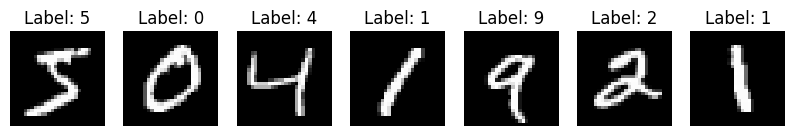

In [ ]:
# num_samples = len(train_dataset)
# print(f"Number of samples in the training dataset: {num_samples}")
# Number of samples in the training dataset: 60000

num_samples = 7
samples = [train_dataset[i] for i in range(num_samples)]

# Visualize
fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))

for i, (image, label) in enumerate(samples):
    axes[i].imshow(image.squeeze(), cmap="gray")  # squeeze removes dimensions of size 1
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")  # Hide axes ticks

plt.show()


In [ ]:
# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True  # Shuffle training data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,  # Adjust batch size as needed
    shuffle=False  # No need to shuffle testing data
)

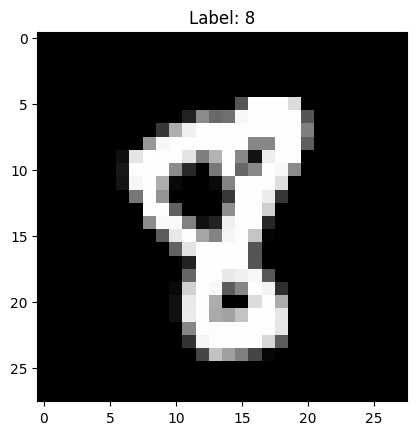

In [ ]:
img, label = next(iter(train_loader))
plt.imshow(img[0, 0], cmap="gray")
plt.title(f"Label: {label[0]}")
plt.show()


In [ ]:
#PLAYING AROUND: Implementing Type A and Type B masked 3x3 convolutions on a 5x5 image
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

# Example usage:
# Input image (5x5)
image = torch.randn(1, 1, 5, 5)  # Batch size 1, 1 channel

# Type A masked convolution
type_A_conv = MaskedConv2d(1, 16, kernel_size=3, mask_type='A')  # in_channels=1, out_channels=16
type_A_output = type_A_conv(image)

# Type B masked convolution
type_B_conv = MaskedConv2d(16, 16, kernel_size=3, mask_type='B')  # in_channels=16, out_channels=16
type_B_output = type_B_conv(type_A_output)

print(type_A_output.shape)  # Output shape: (1, 16, 3, 3)
print(type_B_output.shape)  # Output shape: (1, 16, 1, 1)

torch.Size([1, 16, 3, 3])
torch.Size([1, 16, 1, 1])


In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type, **kwargs):
        super().__init__(*args, padding = 1, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module): # Defining the model architecture using MaskedConv2d layers, ReLU activations, and a final output layer.
  def __init__(self, input_channels=1, hidden_channels=64, output_channels=256, num_hidden_layers = 4):  # 256 output channels for 0-255 pixel values
        super(PixelCNN, self).__init__()
        #manually defining input, hidden and output layers
        # self.layers = nn.Sequential(
        #     MaskedConv2d(input_channels, hidden_channels, kernel_size=3, mask_type='A'),
        #     nn.ReLU(),
        #     MaskedConv2d(hidden_channels, hidden_channels, kernel_size=3, mask_type='B'),
        #     nn.ReLU(),
        #     # ... (add more layers if needed)
        #     nn.Conv2d(hidden_channels, output_channels, kernel_size=1)  # Output layer for pixel value distribution
        # )

        # looping it with the hidden layer variable
        layers = [MaskedConv2d(input_channels, hidden_channels, kernel_size=3, mask_type='A'), nn.ReLU()]
        for _ in range(num_hidden_layers):
            layers.extend([MaskedConv2d(hidden_channels, hidden_channels, kernel_size=3, mask_type='B'), nn.ReLU()])
        layers.append(nn.Conv2d(hidden_channels, output_channels, kernel_size=1)) #would add nn.Sigmoid() if not discrete  # Sigmoid to constrain output to 0-1
        self.layers = nn.Sequential(*layers)
        #the kernel_size arguement corresponds to the overall size of the convolutional kernel, which in ur case is the 3x3 mask, it will cover a 3x3 patch of the input image

  def forward(self, x):
      return self.layers(x)

# hyperparameters
input_channels = 1  # For grayscale images #will be = 3 if RGB
hidden_channels = 64
output_channels = 256  # 256 classes for pixel values 0-255 # will be 1 if continuous pixel values for single output channel
learning_rate = 0.001
batch_size = 64
epochs = 10


# Initialize model, optimizer, and loss function
model = PixelCNN(input_channels, hidden_channels, output_channels)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
#criterion = nn.MSELoss()  # Use Mean Squared Error for regression

# Learning Rate Finder (Optional but recommended)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

# # Scheduler
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs) # Adjust max_lr as needed


# Training loop
# with timing and model saving
start_time = time.time()  # Start the timer
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.long()[:, 0]) #, :18, :18])  # Reshape target and convert to long # added [:, 0, :18, :18] in this line
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished!")

end_time = time.time()  # Stop the timer
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10], Batch [1/938], Loss: 5.5148
Epoch [1/10], Batch [101/938], Loss: 0.9153
Epoch [1/10], Batch [201/938], Loss: 0.8377
Epoch [1/10], Batch [301/938], Loss: 0.8350
Epoch [1/10], Batch [401/938], Loss: 0.8211
Epoch [1/10], Batch [501/938], Loss: 0.8083
Epoch [1/10], Batch [601/938], Loss: 0.8062
Epoch [1/10], Batch [701/938], Loss: 0.8149
Epoch [1/10], Batch [801/938], Loss: 0.8080
Epoch [1/10], Batch [901/938], Loss: 0.8365
Epoch [2/10], Batch [1/938], Loss: 0.7765
Epoch [2/10], Batch [101/938], Loss: 0.7700
Epoch [2/10], Batch [201/938], Loss: 0.8412
Epoch [2/10], Batch [301/938], Loss: 0.7973
Epoch [2/10], Batch [401/938], Loss: 0.8239
Epoch [2/10], Batch [501/938], Loss: 0.7753
Epoch [2/10], Batch [601/938], Loss: 0.8410
Epoch [2/10], Batch [701/938], Loss: 0.7992
Epoch [2/10], Batch [801/938], Loss: 0.7724
Epoch [2/10], Batch [901/938], Loss: 0.7695
Epoch [3/10], Batch [1/938], Loss: 0.7884
Epoch [3/10], Batch [101/938], Loss: 0.7704
Epoch [3/10], Batch [201/938], Loss: 0

RuntimeError: Parent directory /content/drive/MyDrive/Projects/trained_model does not exist.

Explanation of Key Parts:

- PixelCNN Model: Defines the model architecture using MaskedConv2d layers, ReLU activations, and a final output layer.

- Output Channels: The output_channels is set to 256 to represent the 256 possible pixel values (0-255). This means you need 256 outputs per pixel when modeling it as classification.

- Loss Function: nn.CrossEntropyLoss is used as it's suitable for multi-class classification.

- Training Loop: Iterates through epochs and batches, calculates loss, and updates model parameters.

- Target: The target is the same as the input image because PixelCNN learns to predict each pixel based on the preceding ones.

- Data Reshaping: The target (data) is reshaped using view(-1) to match the output shape of the model. It's also converted to long data type for CrossEntropyLoss.


Further Improvements:
- Add more layers and channels: For better performance, you can experiment with deeper and wider architectures.
- Gated PixelCNN: Implement the gated version for more sophisticated conditional dependencies.
- Other datasets: Try training on different image datasets for broader applicability.
- Evaluation: Add evaluation metrics to assess the model's performance on a held-out test set

In [ ]:

# Save the trained model
model_save_path = "/content/drive/MyDrive/Projects/pixelcnn_model.pth"  # Choose a file path
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Projects/pixelcnn_model.pth


In [ ]:
# --- OLD Image Generation ---

def generate_image(model, image_size=(8, 8)):
    """Generates a new image using the PixelCNN model."""
    model.eval()  # Sets the model to evaluation mode
    image = torch.zeros(1, 1, *image_size)  # Starts with an empty image

    for i in range(image_size[0]):
        for j in range(image_size[1]):
            # Predict the pixel value at (i, j)
            output = model(image)
            probs = torch.softmax(output[:, :, i, j], dim=1)  # Get probabilities for each pixel value
            pixel_value = torch.multinomial(probs, num_samples=1).item()  # Sample a pixel value

            # Update the image with the predicted pixel value
            image[0, 0, i, j] = pixel_value

    return image

In [ ]:
#GIVES NONSENSE GENERATION

def generate_image(model, image_size=(8, 8), num_layers=4): # changed image_size to 8x8
    """Generates a new image using the PixelCNN model."""
    model.eval()
    # image = torch.zeros(1, 1, *image_size)
    margin = 2 * num_layers # margin to avoid the dimension mismatch
    input_size = (image_size[0] + margin, image_size[1] + margin) # input_size that will be fed to the model
    #image = torch.zeros(1, 1, *input_size)  # starts with an empty image with size 16x16
    image = torch.randint(0, 256, (1, 1, *input_size)).float() # starts with a random image with size 16x16


    for i in range(image_size[0]):
        for j in range(image_size[1]):
            output = model(image)

            # Dynamically calculate index based on the receptive field
            # You might need to adjust the calculation based on your specific model architecture
            index_i = i + margin // 2
            index_j = j + margin // 2

            # Check if the indices are within the bounds of the output tensor
            if 0 <= index_i < output.shape[2] and 0 <= index_j < output.shape[3]:
              probs = torch.softmax(output[:, :, index_i, index_j], dim=1) #accessing the correct portion of the output
              pixel_value = torch.multinomial(probs, num_samples=1).item()
              image[0, 0, index_i, index_j] = pixel_value # modifying the correct part of the image

    # Center crop the generated image to get the desired dimensions
    generated_image = image[0, 0, margin//2:image_size[0] + margin//2, margin//2:image_size[1] + margin//2] # getting the 8x8 final image
    return generated_image

In [ ]:
#NEWWW
def generate_image(model, image_size=28, device='cpu'):
    model.eval()
    generated = torch.zeros((1, 1, image_size, image_size), device=device)  # Start with zeros

    with torch.no_grad():
        for i in range(image_size):
            for j in range(image_size):
                #print("Generated input shape:", generated.shape)  # 👈 Add this
                output = model(generated)
                #print("Model output shape:", output.shape)        # 👈 Add this
                pixel_dist = output[0, :, i, j]
                probs = torch.softmax(pixel_dist, dim=0)
                pixel_value = torch.multinomial(probs, 1).item() #float() / 255.0
                #pixel_value = torch.argmax(probs).item()
                generated[0, 0, i, j] = pixel_value/ 255.0

    return generated.cpu()



In [ ]:
# sample = generate_image(model.to(device),  image_size=18, device=device)
# print("Generated input shape:", generated.shape)  # should be [1, 1, 28, 28]
# output = model(generated)
# print("Model output shape:", output.shape)        # check this!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#generate and save images

num_images = 100
generated_images_path = os.path.join(output_file, "MNIST", "./generated_images")  # Path to save generated images
os.makedirs(generated_images_path, exist_ok=True)  # Create the directory if it doesn't exist

for i in range(num_images):
    generated_image = generate_image(model)

    # Save the generated image
    image_save_path = os.path.join(generated_images_path, f"generated_image_{i + 1}.png")
    torchvision.utils.save_image(generated_image, image_save_path)  # Save as PNG
print(f"Generated images saved to: {generated_images_path}")

#visualize some generated images

# sample = generate_image(model.to(device), image_size=28, device=device)
# plt.imshow(sample.squeeze(), cmap='gray')
# plt.title("Generated Digit")
# plt.axis('off')
# plt.show()



Generated images saved to: /content/drive/MyDrive/Projects/MNIST/./generated_images


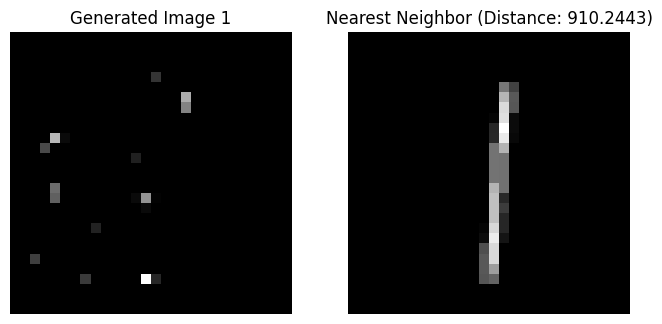

Distance to nearest neighbor for image 1: 910.2443


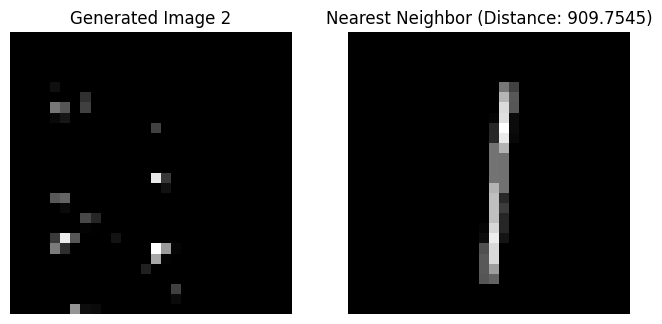

Distance to nearest neighbor for image 2: 909.7545


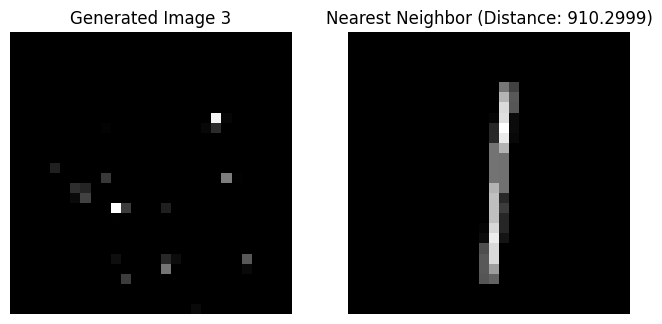

Distance to nearest neighbor for image 3: 910.2999


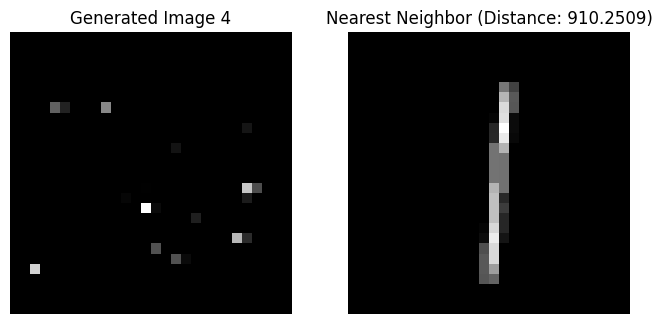

Distance to nearest neighbor for image 4: 910.2509


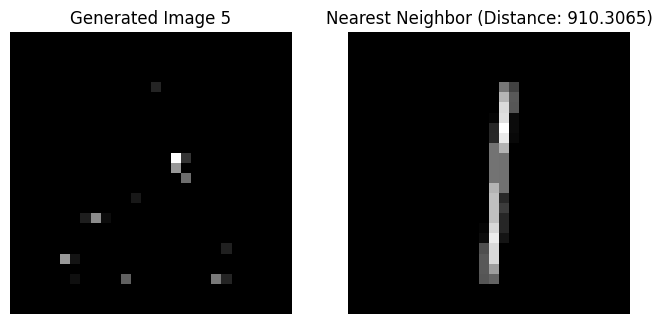

Distance to nearest neighbor for image 5: 910.3065


In [ ]:
#checking if model is memorizing training data
# 2 methods: KNN: IF the distances are consistently very small,
# it suggests that the model might be memorizing training data rather than learning to generate novel digits. OR

# FID (Fréchet Inception Distance): compares the distributions of real and generated images using features extracted from a pre-trained
# Inception network. Lower FID scores generally indicate better quality and diversity of generated samples.

def nearest_neighbor_search(generated_image, train_dataset):
    """Finds the nearest neighbor of a generated image in the training dataset."""
    distances = []
    for train_image, _ in train_dataset:
        distance = torch.dist(generated_image.flatten(), train_image.flatten())
        distances.append(distance)

    nearest_index = torch.argmin(torch.tensor(distances))
    nearest_image = train_dataset[nearest_index][0]

    return nearest_image, distances[nearest_index]

# Path to the generated images
generated_images_path = os.path.join(output_file, "MNIST", "./generated_images")
num_images = 5
# Example usage
for i in range(num_images):
    generated_image = generate_image(model)
    nearest_image, distance = nearest_neighbor_search(generated_image, train_dataset)

    # Visualize the generated image and its nearest neighbor
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns for images

    axes[0].imshow(generated_image.squeeze(), cmap='gray')
    axes[0].set_title(f"Generated Image {i + 1}")
    axes[0].axis('off')

    axes[1].imshow(nearest_image.squeeze(), cmap='gray')
    axes[1].set_title(f"Nearest Neighbor (Distance: {distance:.4f})")
    axes[1].axis('off')

    plt.show()

    print(f"Distance to nearest neighbor for image {i + 1}: {distance:.4f}")

In [ ]:
#using FID will be something ike this
from pytorch_fid import fid_score

# --- FID Calculation ---

# Define paths to real and generated images
real_images_path = os.path.join(output_file, "MNIST", "raw")  # Path to a directory containing real MNIST images
generated_images_path = os.path.join(output_file, "MNIST", "./generated_images")  # Path to a directory containing generated images


# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set an appropriate batch size for FID calculation
batch_size = 64  # Or any other positive integer

# Calculate FID score
fid = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size, device, dims=2048)

print(f"FID score: {fid:.4f}")

In [ ]:
print(a)

NameError: name 'a' is not defined

In [ ]:
class ConditionalMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        return img, label, label  # input, pixel_target, digit_class

    def __len__(self):
        return len(self.mnist)


In [ ]:
#Can you condition the model to generate a specific digit (e.g., “generate a 4”)? What architectural change would allow this?

class ConditionalPixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, output_channels=256, num_classes=10, num_hidden_layers=4):
        super(ConditionalPixelCNN, self).__init__()

        self.embedding = nn.Embedding(num_classes, hidden_channels)  # Class embedding layer

        # Fixed: Corrected input channels for the first MaskedConv2d layer
        layers = [MaskedConv2d(input_channels + hidden_channels, hidden_channels, kernel_size=3, mask_type='A'), nn.ReLU()]
        for _ in range(num_hidden_layers):
            # Fixed: Corrected input channels for subsequent MaskedConv2d layers to match the output of the previous layer
            layers.extend([MaskedConv2d(hidden_channels, hidden_channels, kernel_size=3, mask_type='B'), nn.ReLU()])
        layers.append(nn.Conv2d(hidden_channels, output_channels, kernel_size=1)) # Corrected: Input channels to final conv layer
        self.layers = nn.Sequential(*layers)

    def forward(self, x, class_label):
        class_embedding = self.embedding(class_label)  # Get class embedding

        # Reshape and tile the embedding to match the input shape
        class_embedding = class_embedding.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        class_embedding = class_embedding.repeat(1, 1, x.shape[2], x.shape[3])  # Tile to match input size

        # Concatenate the embedding with the input
        x = torch.cat([x, class_embedding], dim=1)

        return self.layers(x)

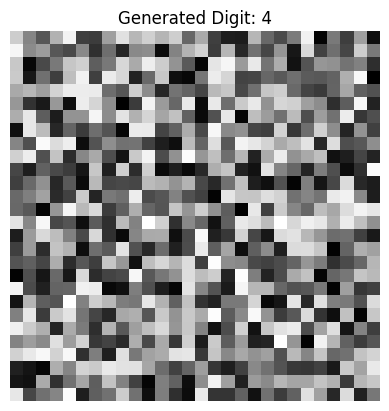

In [ ]:
# Create an instance of the model
model = ConditionalPixelCNN(input_channels=1, hidden_channels=64, output_channels=256, num_classes=10, num_hidden_layers=4)

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the device

# Function to generate an image of a specific digit
def generate_digit(model, digit, image_size=28):
    model.eval()  # Set the model to evaluation mode
    class_label = torch.tensor([digit], device=device)  # Create the class label tensor
    generated = torch.zeros((1, 1, image_size, image_size), device=device)  # Start with zeros

    with torch.no_grad():
        for i in range(image_size):
            for j in range(image_size):
                output = model(generated, class_label)  # Pass the class label to the model
                pixel_dist = output[0, :, i, j]
                probs = torch.softmax(pixel_dist, dim=0)
                pixel_value = torch.multinomial(probs, 1).item()
                generated[0, 0, i, j] = pixel_value / 255.0  # Normalize to 0-1

    return generated.cpu()  # Move the generated image back to CPU

# Generate the digit "4"
generated_image = generate_digit(model, digit=4)

# Visualize the generated image
plt.imshow(generated_image.squeeze(), cmap='gray')
plt.title("Generated Digit: 4")
plt.axis('off')
plt.show()

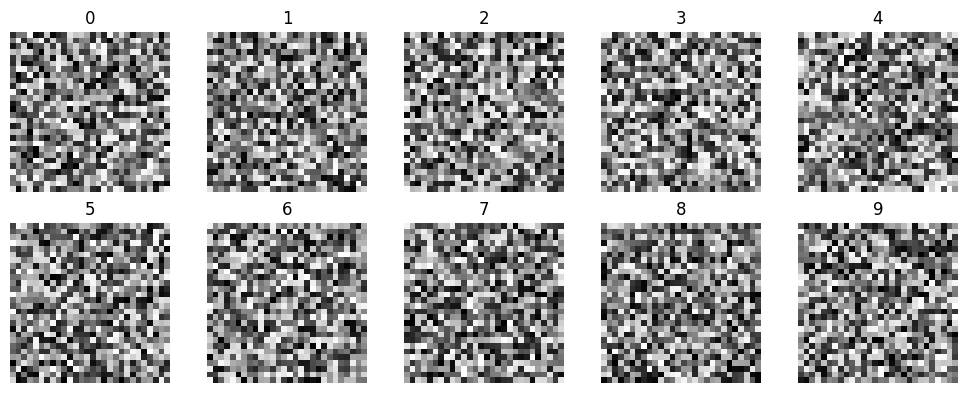

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for digit in range(10):
    img = generate_digit(model, digit)
    axes[digit // 5, digit % 5].imshow(img.squeeze(), cmap="gray")
    axes[digit // 5, digit % 5].set_title(str(digit))
    axes[digit // 5, digit % 5].axis("off")
plt.tight_layout()
plt.show()

In [ ]:

# TRIAL_Fixed: Conditional generation with proper sampling and label injection

def generate_image(model, digit=None, image_size=28, device='cpu'):
    model.eval()
    generated = torch.zeros((1, 1, image_size, image_size), device=device)

    if digit is not None:
        label = torch.tensor([digit], device=device)
    else:
        label = None

    with torch.no_grad():
        for i in range(image_size):
            for j in range(image_size):
                if label is not None:
                    output = model(generated, label)
                else:
                    output = model(generated)
                pixel_dist = output[0, :, i, j]
                probs = torch.softmax(pixel_dist, dim=0)
                pixel_value = torch.multinomial(probs, 1).item()
                generated[0, 0, i, j] = pixel_value / 255.0

    return generated.cpu()


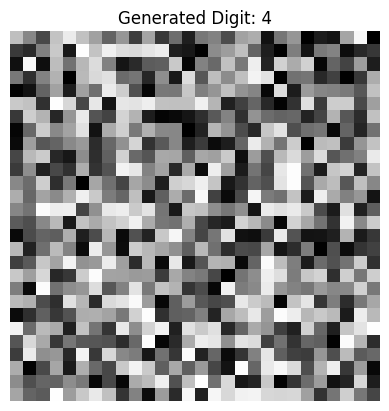

In [ ]:

# Example: Generate digit "4" with ConditionalPixelCNN
digit = 4
generated = generate_image(model, digit=digit, device=device)

plt.imshow(generated.squeeze(), cmap='gray')
plt.title(f"Generated Digit: {digit}")
plt.axis('off')
plt.show()
